<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/causal-inference/propensity_score_matching_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook does PSM using more covariates including % White, % Hispanic. And the data with <= 200 device_counts are filtered out.

# 0. load some R packages

In [2]:
cd drive/My\ Drive/week5

/content/drive/My Drive/week5


In [3]:
# if we don't do this there will be annoying warnings
# for using some of the R in jupyter...
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = RRuntimeWarning)

In [4]:
# enable R to python in Colab
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
import numpy as np
import pandas as pd

# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [6]:
%%R
# install standard propensity matching library in R 
install.packages("MatchIt")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘Matching’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/Matching_4.9-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 298404 bytes (291 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [7]:
%%R
# load MatchIt package
library(MatchIt)

In [8]:
%%R
# install Coarsened Exact Matching package
install.packages('cem')
library(cem)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘combinat’, ‘randomForest’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/combinat_0.0-8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 9197 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

# 1. Propensity score matching with new data without low device count + new covariates

In [9]:
ls

agg_social_dist_2.csv                 county_data_with_reduced_covariates.csv
county_data_with_and_without_SIP.csv  propensity_score_matching_2.ipynb
county_data_with_covariates.csv       propensity_score_matching.ipynb


In [12]:
dataframe = pd.read_csv("county_data_with_reduced_covariates.csv")

In [13]:
# look at our data
dataframe.head()

,state,state_code,State Name,cnamelong,county_code,%diff_stay_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001,0.119839,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003,0.112319,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005,0.071000,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007,0.089074,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009,0.098240,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9


In [14]:
print(f"this dataset has {dataframe.shape[0]} records.")

this dataset has 2799 records.


In [15]:
dataframe.dropna(inplace=True)

In [16]:
print(f"after dropping this dataset has {dataframe.shape[0]} records.")

after dropping this dataset has 2799 records.


So we don't have any null records, which is good

In [23]:
# look at variables we have in R. (% sign is messed up)
%%R -i dataframe
head(dataframe)

  state state_code State.Name      cnamelong county_code X.diff_stay_at_home
0     1         AL    Alabama Autauga County        1001          0.11983891
1     1         AL    Alabama Baldwin County        1003          0.11231890
2     1         AL    Alabama Barbour County        1005          0.07100017
3     1         AL    Alabama    Bibb County        1007          0.08907352
4     1         AL    Alabama  Blount County        1009          0.09824028
5     1         AL    Alabama Bullock County        1011          0.06304790
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4        10138 

In [24]:
# -i means pass in some argument/data from python world to R world
%%R -i dataframe

# using MatchIt package to do PSM - guess it used logistic regression?

m.out <- matchit(SIP.~Median.Household.Income + X..Rural +
                 political_diff+
                 X..Asian + X..Black + 
                 X..Non.Hispanic.White +
                 X..Hispanic,
                 method = "cem", data = dataframe) # cem = coarse exact matching


Using 'treat'='1' as baseline group


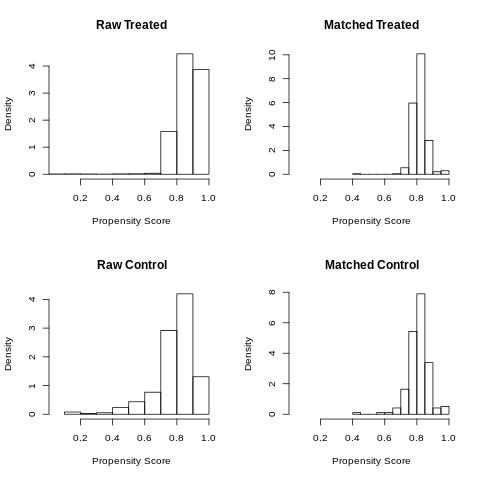

In [25]:
# to see how maching it soind by visualizing distributions
%%R
plot(m.out, type='hist')

[1] "To identify the units, use first mouse button; to stop, use second."
integer(0)


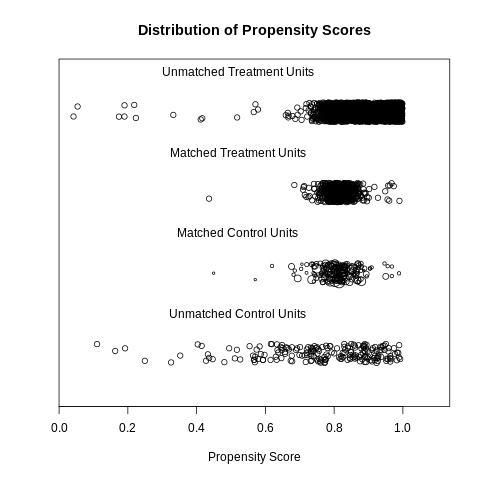

In [26]:
%%R
plot(m.out, type='jitter')

In [27]:
%%R
summary(m.out, standardize=T)


Call:
matchit(formula = SIP. ~ Median.Household.Income + X..Rural + 
    political_diff + X..Asian + X..Black + X..Non.Hispanic.White + 
    X..Hispanic, data = dataframe, method = "cem")

Summary of balance for all data:
                        Means Treated Means Control SD Control Std. Mean Diff.
distance                       0.8720        0.7881     0.1284          0.9930
Median.Household.Income    53305.7666    52935.0716 10528.3377          0.0253
X..Rural                      53.8051       61.4046    28.3571         -0.2488
political_diff                -0.2779       -0.4133     0.2214          0.4364
X..Asian                       1.7189        1.0529     1.3405          0.2210
X..Black                      10.6841        4.3946     9.6598          0.4133
X..Non.Hispanic.White         74.7230       81.8980    14.3729         -0.3535
X..Hispanic                   10.0189        6.7136     6.3801          0.2306
                        eCDF Med eCDF Mean eCDF Max
distance      

we can see from the histogram and jitter plot and summary statistics that this matching is pretty good! - Std. Mean Diff are all $\le$ 0.05, which is good

In [28]:
%%R
# extract matched data.
matched_data <- match.data(m.out)

In [29]:
# import dataframe from R to python.... since I am not familar with manipulating
# R objects 
matched_data = %R matched_data

In [30]:
no_SIP_diff = ((matched_data[matched_data['SIP.'] == 0]['weights'] / \
 matched_data[matched_data['SIP.'] == 0]['weights'].sum()) \
* matched_data[matched_data['SIP.'] == 0]['X.diff_stay_at_home']).sum()

In [31]:
SIP_diff = matched_data[matched_data['SIP.'] == 1]['X.diff_stay_at_home'].mean()

In [32]:
SIP_diff - no_SIP_diff

0.016483459567586484

# Conclusion

our percentage this time comes out to be 1.64%, which is higher than the past analysis we tried, which tends to be around 1.5%. This difference seems to be consistent after we cleaned the data a bit and added a few more covariates. Which is good.